In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

In [2]:
df=pd.read_csv('train.csv',nrows =3_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 183.1+ MB


In [4]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,3.000000e+06,3.000000e+06,3.000000e+06,2.999977e+06,2.999977e+06,3.000000e+06
mean,1.134246e+01,-7.250894e+01,3.992033e+01,-7.250740e+01,3.991728e+01,1.684528e+00
std,9.828907e+00,1.320223e+01,8.644440e+00,1.308827e+01,9.984419e+00,1.329084e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.408430e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398015e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


# Additional research

In [5]:
# Знаходимо різниці локації старту і фінішу поїздки 
df['difference_longitude']=np.abs(np.asarray(df['pickup_longitude']-df['dropoff_longitude']))
df['difference_latitude']=np.abs(np.asarray(df['pickup_latitude']-df['dropoff_latitude']))

df=df[(df['difference_longitude']<5.0)&(df['difference_latitude']<5.0)]

In [6]:
#Шукаємо дистанцію поїздки
R = 6373.0
lat1 = np.asarray(np.radians(df['pickup_latitude']))
lon1 = np.asarray(np.radians(df['pickup_longitude']))
lat2 = np.asarray(np.radians(df['dropoff_latitude']))
lon2 = np.asarray(np.radians(df['dropoff_longitude']))

dlon = lon2 - lon1
dlat = lat2 - lat1
ls1=[] 
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/ 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
distance = R * c

df['distance']=np.asarray(distance)*0.621

In [7]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,difference_longitude,difference_latitude,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,0.640305
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,5.249180
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,0.863166
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,1.738893
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,1.241866


In [8]:
#Знаходимо день тижня, коли відбулася поїздка
ls1=list(df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i]=ls1[i][:-4:]
    ls1[i]=pd.Timestamp(ls1[i])
    ls1[i]=ls1[i].weekday()
df['weekday']=ls1
#0 - Monday
#1 - Tuesday
# ...

In [9]:
#Знаходимо час старту поїздки
ls1=list(df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i]=ls1[i][11:-7:]
df['pickup_time']=ls1 

In [10]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,difference_longitude,difference_latitude,distance,weekday,pickup_time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,0.640305,0,17:26
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,5.249180,1,16:52
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,0.863166,3,00:35
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,1.738893,5,04:30
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,1.241866,1,07:51


In [11]:
#Переведемо час у цілочисельне значення
ls1=list(df['pickup_time'])
for i in range(len(ls1)):
    z=ls1[i].split(':')
    ls1[i]=int(z[0])*100+int(z[1])
df['pickup_time']=ls1

df.drop('pickup_datetime',inplace=True,axis=1)

In [12]:
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,difference_longitude,difference_latitude,distance,weekday,pickup_time
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,0.640305,0,1726
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,5.249180,1,1652
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,0.863166,3,35
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,1.738893,5,430
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,1.241866,1,751


In [13]:
#фільтрація даних
df_filtered = df
df_filtered = df_filtered.drop(columns=['pickup_latitude','pickup_longitude','dropoff_longitude',"dropoff_latitude"])

In [14]:
df_filtered.describe()

,fare_amount,passenger_count,difference_longitude,difference_latitude,distance,weekday,pickup_time
count,2.993901e+06,2.993901e+06,2.993901e+06,2.993901e+06,2.993901e+06,2.993901e+06,2.993901e+06
mean,1.133517e+01,1.684592e+00,2.250499e-02,2.110416e-02,2.046682e+00,3.041368e+00,1.380738e+03
std,9.806777e+00,1.329070e+00,3.881602e-02,2.871790e-02,2.716795e+00,1.949572e+00,6.516744e+02
min,-6.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.000000e+00,5.792000e-03,6.578000e-03,7.522364e-01,1.000000e+00,9.250000e+02
50%,8.500000e+00,1.000000e+00,1.240500e-02,1.383000e-02,1.311512e+00,3.000000e+00,1.439000e+03
75%,1.250000e+01,2.000000e+00,2.359200e-02,2.682500e-02,2.395367e+00,5.000000e+00,1.932000e+03
max,1.273310e+03,2.080000e+02,4.951542e+00,4.991325e+00,3.994101e+02,6.000000e+00,2.359000e+03


c:\users\lenovik\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


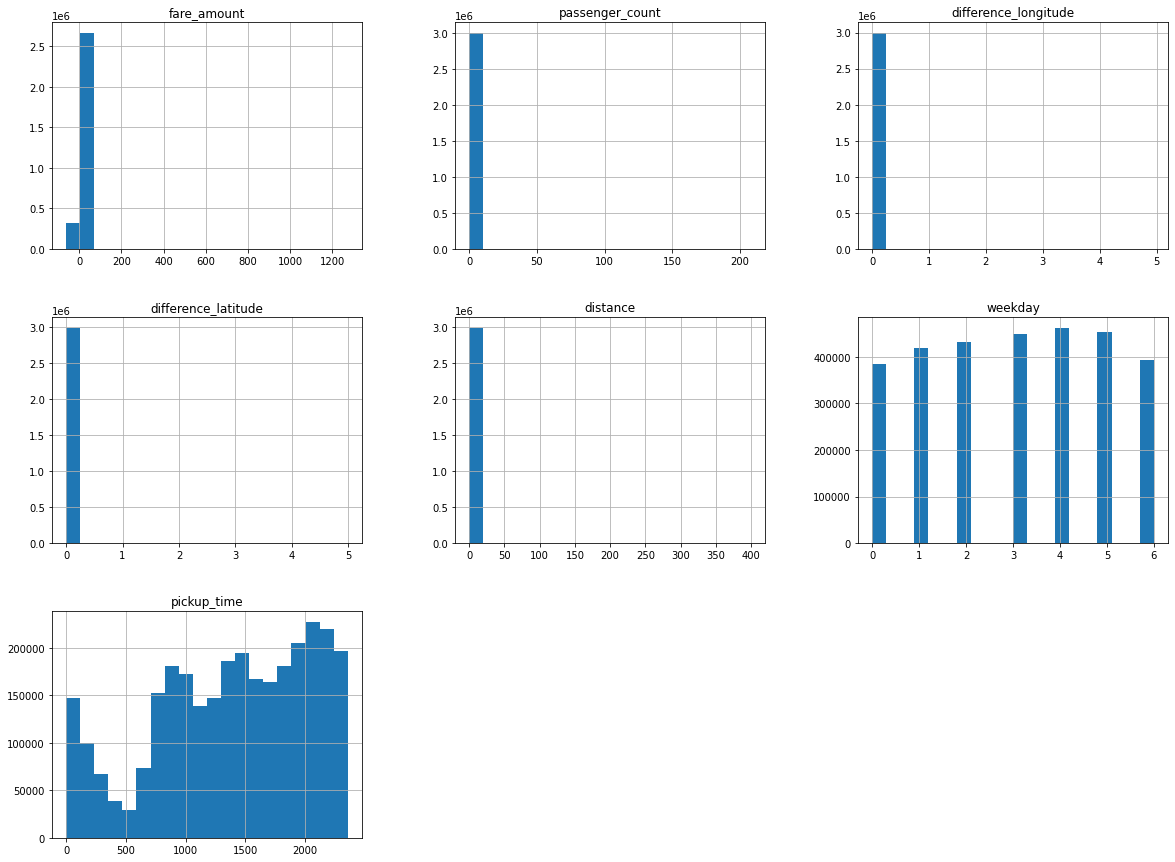

In [15]:
df_filtered.hist(bins=20,figsize = (20,15))
plt.show()

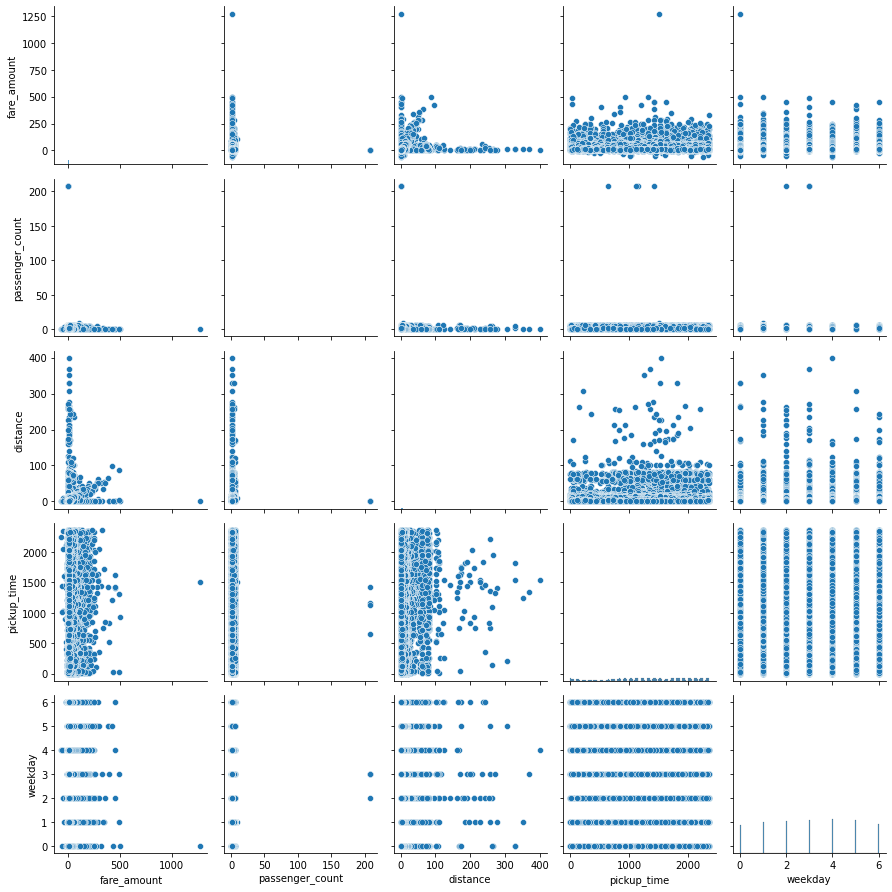

In [16]:
columns = ['fare_amount','passenger_count','distance','pickup_time','weekday']
sns.pairplot(df_filtered[columns]);
plt.tight_layout();
plt.show()
#Лінійні залежності між різними характеристиками

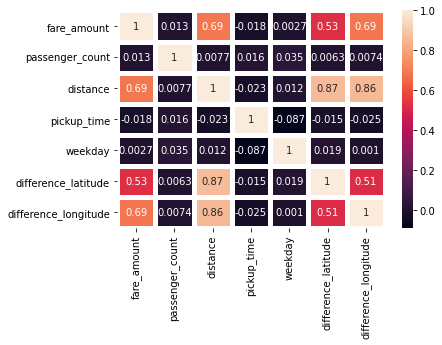

In [17]:
#матриція кореляції
columns = ['fare_amount','passenger_count','distance','pickup_time','weekday','difference_latitude','difference_longitude']
cm=df_filtered[columns].corr()
hm=sns.heatmap(data = cm,
               cbar = True,
               annot = True,
               square = False,
               xticklabels = columns,
               yticklabels = columns,
               linewidths = 5)
plt.show()

c:\users\lenovik\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='weekday', ylabel='pickup_time'>

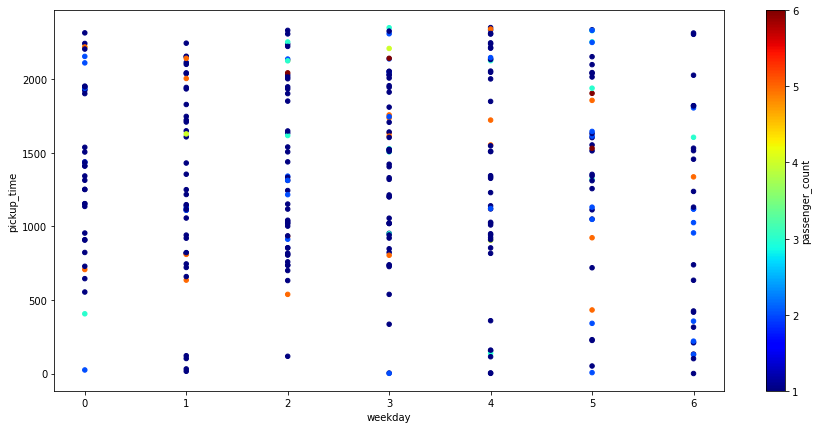

In [18]:
sample = df_filtered.sample(n=300)
sample.plot(kind="scatter",
            y="pickup_time",
            x="weekday",
            c="passenger_count",
            figsize=(15,7),
            cmap=plt.get_cmap("jet"),
            colorbar=True,
            sharex=False)
#можемо побачити співвідношення між днем тижня та часом старту поїздки, враховуючи кількость пасажирів у таксі

# Linear Regression

Sklearn Training

In [19]:
X = df[['passenger_count','distance','pickup_time','weekday']]
y = df['fare_amount']

#Розбиття даних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [20]:
polinomial_degree = 2;
polynomial_features = PolynomialFeatures(degree=polinomial_degree,include_bias=False)
linear_regression = LinearRegression(normalize=True)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomial_features', PolynomialFeatures(include_bias=False)),
                ('linear_regression', LinearRegression(normalize=True))])

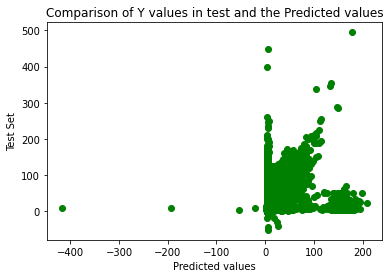

In [21]:
y_predicted = pipeline.predict(X_test)

plt.title('Comparison of Y values in test and the Predicted values')
plt.ylabel('Test Set')
plt.xlabel('Predicted values')
plt.scatter(y_predicted, y_test, color='green')
plt.show()

In [22]:
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

Mean absolute error: 2.8005996910705417
Mean squared error: 37.96767159293264
Root mean squared error: 6.161791264959617


In [23]:
delta = abs(y_test.values - y_predicted)

index = np.argmax(delta) 
max_val = np.max(delta)
print('Index: ', index,'\nMax value: ',max_val)

Index:  728935 
Max value:  444.70370745123074


In [24]:
X_test.iloc[index]

passenger_count       1.000000
distance              0.001226
pickup_time        1625.000000
weekday               2.000000
Name: 287638, dtype: float64

In [25]:
print("Predicted: ", y_predicted[index], "\nFrom dataset: ", y_test.iloc[index])

Predicted:  5.296292548769255 
From dataset:  450.0


Custom 

In [26]:
def normalize(X):
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    X_new = (X - mean)/std
    
    return X_new, mean, std

In [27]:
def prepare_X(X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.array(X[:])
    X_new = np.column_stack((ones, X_new))
    return X_new

In [28]:
def cost_function(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    J = sum((hypothesis(X,theta) - y)**2)/(2*m);
    return J

In [29]:
def hypothesis(X, theta):
    h_thetha = X.dot(theta);
    return h_thetha

In [30]:
def derivative(X, y, theta):
    m = X.shape[0]
    d_thetha = np.dot(hypothesis(X, theta) - y, X) / m
    return d_thetha

In [31]:
def gradient_descent(X, y, theta, alpha, num_iters, print_J = True):
    m = X.shape[0]
    J_history = []
    J = cost_function(X, y, theta)
    if print_J == True:
        print(J)
    J_history.append(J)
    for i in range(num_iters):
        delta = derivative(X, y, theta)
        theta = theta - alpha*delta
        J = cost_function(X, y, theta)
        if print_J == True:
            print(J)
        J_history.append(J)
    return theta, J_history

In [32]:
def predict(X, mean, std, theta):
    temp = (X - mean) / std
    x = prepare_X(temp)
    predicted = hypothesis(x, theta);
    return predicted

In [33]:
X_train_norm, mean, std = normalize(X_train)
X = prepare_X(X_train_norm)
theta = np.array([0,0,0,0,0])

In [34]:
y = y_train[:]

In [35]:
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))
print(cost_function(X, y, theta))

X: (2095730, 5)
y: (2095730,)
112.31243448409644


In [36]:
alpha = 0.01
num_iters = 1500
new_theta, Js = gradient_descent(X, y, theta, alpha, num_iters, False)
print('New_Theta:', new_theta)
print('\nTheta 0: {}, \nTheta 1: {}'.format(new_theta[0], new_theta[1]))

New_Theta: [11.33109194  0.07867627  6.75440305 -0.02445289 -0.05811565]

Theta 0: 11.33109193648323, 
Theta 1: 0.0786762727701422


In [37]:
predicted = predict(X_test, mean, std, new_theta)

In [38]:
print('Mean absolute error: ', metrics.mean_absolute_error(y_test, predicted))
print('Mean squared error: ', metrics.mean_squared_error(y_test, predicted))
print('Root mean squared error: ', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean absolute error:  3.279109666174171
Mean squared error:  49.57822012951784
Root mean squared error:  7.041180307982309


In [39]:
delta = abs(y_test.values - y_predicted)

index = np.argmax(delta) 
max_val = np.max(delta)
print('Index: ', index,'\nMax value: ',max_val)

Index:  728935 
Max value:  444.70370745123074


In [40]:
X_test.iloc[index]

passenger_count       1.000000
distance              0.001226
pickup_time        1625.000000
weekday               2.000000
Name: 287638, dtype: float64

In [41]:
print("Predicted: ", predicted[index], "\nFrom dataset: ", y_test.iloc[index])

Predicted:  6.238318310181779 
From dataset:  450.0
